In [ ]:
#Import Drive from Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting the current working directory
import os; os.chdir('/content/drive/MyDrive/Colab Notebooks/Plant seedling classification data')

**Part FOUR**

Import Library and settings

In [ ]:
import tensorflow as tf
from keras.applications import xception
from keras.preprocessing import image 
import keras.preprocessing.image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import sklearn.ensemble
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm
from glob import glob
import cv2
import os
import seaborn as sns
import mpl_toolkits.axes_grid1
import matplotlib
import matplotlib.pyplot as plt
import datetime
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

# start timer
global_start = datetime.datetime.now();

# validation set size
valid_set_size_percentage = 10; # default = 10%

# kaggle
running_on_kaggle = True # set True when running on kaggle

# train data
take_only_samples_of_train_data = True; # set False to train on all train data
num_samples_of_train_data_per_species = 200 # < 221, ignored if take_only_samples_of_train_data = True
load_bf_of_train_data = False # set True to load bottleneck features from file

# test data
take_only_samples_of_test_data = False; # set False to predict on all test data
num_samples_of_test_data = 200 # < 794, ignored if take_only_samples_of_test_data = True
load_bf_of_test_data = False # set True to load bottleneck features from file

# augmented images
use_aug_data = False # set True to use augmented images
load_bf_of_aug_data = True # set True to load bottleneck features from file

# show plots
show_plots = True # set False to reduce notebook running time

# overview of directories
print('current directory:')
!ls  


current directory:
 Computer_Vision.ipynb	    Predict.png		    x_test_bf.npy
 dummy.pynb		   'Random Forest.csv'	    x_train_valid_bf.npy
'Logistic regression.csv'   sample_submission.csv   y_train_valid.npy
'Neural Network.csv'	    test
'Prediction - Flower.jpg'   train


**1-A) Import the data. Analyse the dimensions of the data and Visualise the data.**

In [ ]:
# current directory
print('current folder :')
!ls 
print('\nfolders containing images of the corresponding species:')
!ls \train

current folder :
 Computer_Vision.ipynb	    Predict.png		    x_test_bf.npy
 dummy.pynb		   'Random Forest.csv'	    x_train_valid_bf.npy
'Logistic regression.csv'   sample_submission.csv   y_train_valid.npy
'Neural Network.csv'	    test
'Prediction - Flower.jpg'   train

folders containing images of the corresponding species:
 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [ ]:
# Read Train and test data
# directories
cw_dir = os.getcwd()
data_dir = '/content/drive/MyDrive/Colab Notebooks/Plant seedling classification data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# different species in the data set
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat',
           'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed',
           'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
num_species = len(species)

# print number of images of each species in the training data
for sp in species:
    print('{} images of {}'.format(len(os.listdir(os.path.join(train_dir, sp))),sp))
    
# read all train data
train = []
for species_id, sp in enumerate(species):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train.append(['train/{}/{}'.format(sp, file), file, species_id, sp])
train_df = pd.DataFrame(train, columns=['filepath', 'file', 'species_id', 'species'])
print('')
print('train_df.shape = ', train_df.shape)

# read all test data
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test_df = pd.DataFrame(test, columns=['filepath', 'file'])
print('test_df.shape = ', test_df.shape)

# function to read an image 
def read_image(filepath, target_size=None):
    img = cv2.imread(os.path.join(data_dir, filepath), cv2.IMREAD_COLOR)
    img = cv2.resize(img.copy(), target_size, interpolation = cv2.INTER_AREA)
    #img = image.load_img(os.path.join(data_dir, filepath),target_size=target_size)
    #img = image.img_to_array(img)
    return img

187 images of Black-grass
343 images of Charlock
285 images of Cleavers
611 images of Common Chickweed
208 images of Common wheat
456 images of Fat Hen
609 images of Loose Silky-bent
178 images of Maize
512 images of Scentless Mayweed
220 images of Shepherds Purse
491 images of Small-flowered Cranesbill
308 images of Sugar beet

train_df.shape =  (4408, 4)
test_df.shape =  (794, 2)


In [ ]:
if False:
    train_df['image_heigth'] = 0
    train_df['image_width'] = 0
    train_df['image_channel'] = 0

    #get all image shapes
    for i in range(len(train_df)):
        img = read_img(train_df.filepath.values[i])
        train_df.loc[i,'image_heigth'] = img.shape[0]
        train_df.loc[i,'image_width'] = img.shape[1]
        train_df.loc[i,'image_channel'] = img.shape[2]

    test_df['image_heigth'] = 0
    test_df['image_width'] = 0
    test_df['image_channel'] = 0

    # get all image shapes
    for i in range(len(test_df)):
        img = read_img(test_df.filepath.values[i])
        test_df.loc[i,'image_heigth'] = img.shape[0]
        test_df.loc[i,'image_width'] = img.shape[1]
        test_df.loc[i,'image_channel'] = img.shape[2]

In [ ]:

# Display train data
#print(train_df.describe())
train_df.head()

,filepath,file,species_id,species
0,train/Black-grass/fef14b865.png,fef14b865.png,0,Black-grass
1,train/Black-grass/f39ddbe0a.png,f39ddbe0a.png,0,Black-grass
2,train/Black-grass/fb487c5a4.png,fb487c5a4.png,0,Black-grass
3,train/Black-grass/f20bf670a.png,f20bf670a.png,0,Black-grass
4,train/Black-grass/ed4b42936.png,ed4b42936.png,0,Black-grass


In [ ]:
# Display Test data
#print(test_df.describe())
test_df.head()

,filepath,file
0,test/f9b6bfb00.png,f9b6bfb00.png
1,test/fea3da57c.png,fea3da57c.png
2,test/f1f7c833f.png,f1f7c833f.png
3,test/fe29629fb.png,fe29629fb.png
4,test/f48916a8c.png,f48916a8c.png


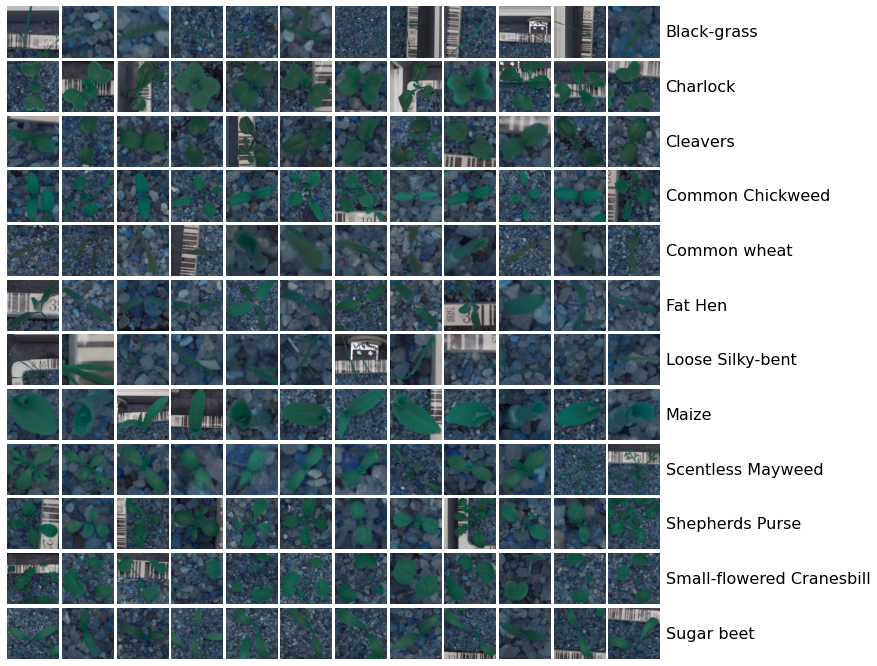

In [ ]:
## Display 12 images of all species of Train data

if show_plots:

    fig = plt.figure(1, figsize=(num_species, num_species))
    grid = mpl_toolkits.axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_species, num_species), 
                                             axes_pad=0.05)
    i = 0
    for species_id, sp in enumerate(species):
        for filepath in train_df[train_df['species'] == sp]['filepath'].values[:num_species]:
            ax = grid[i]
            img = read_image(filepath, (224, 224))
            ax.imshow(img.astype(np.uint8))
            ax.axis('off')
            if i % num_species == num_species - 1:
                ax.text(250, 112, sp, verticalalignment='center')
            i += 1
    plt.show();

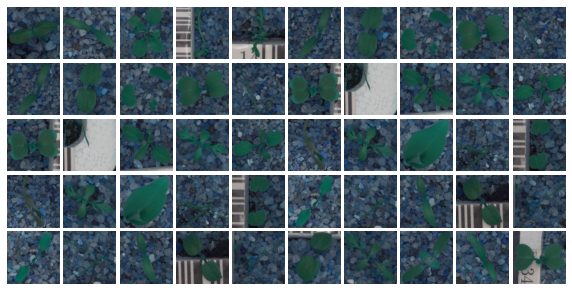

In [ ]:
## show some test images 

if show_plots:

    fig = plt.figure(1, figsize=(10, 10))
    grid = mpl_toolkits.axes_grid1.ImageGrid(fig, 111, nrows_ncols=(5, 10), 
                                             axes_pad=0.05)
    i = 0
    for j in range(5):
        for filepath in test_df['filepath'].values[j*5:j*5+10]:
            ax = grid[i]
            img = read_image(filepath, (224, 224))
            ax.imshow(img.astype(np.uint8))
            ax.axis('off')
            i += 1
    plt.show();

In [ ]:

train_path = '/content/drive/MyDrive/Colab Notebooks/Plant seedling classification data/train/*/*.png' 
test_path = '/content/drive/MyDrive/Colab Notebooks/Plant seedling classification data//test/*.png' 
train_files = glob(train_path)
test_files = glob(test_path)

In [ ]:
## take a fixed number of samples for testing purpose

if take_only_samples_of_train_data:
    train_df = pd.concat([train_df[train_df['species'] == sp][:num_samples_of_train_data_per_species] for sp in species])
    train_df.index = np.arange(len(train_df))

if take_only_samples_of_test_data:
    test_df = test_df[:num_samples_of_test_data]

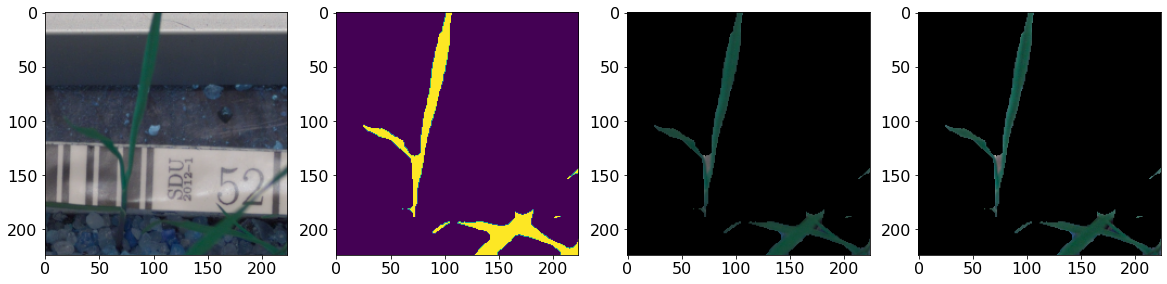

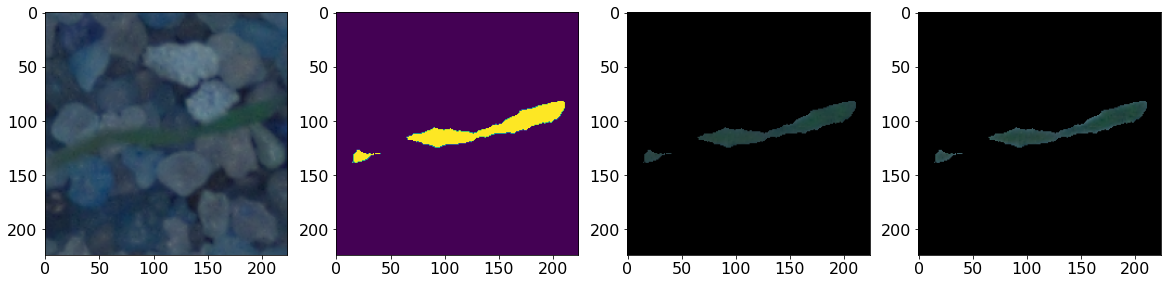

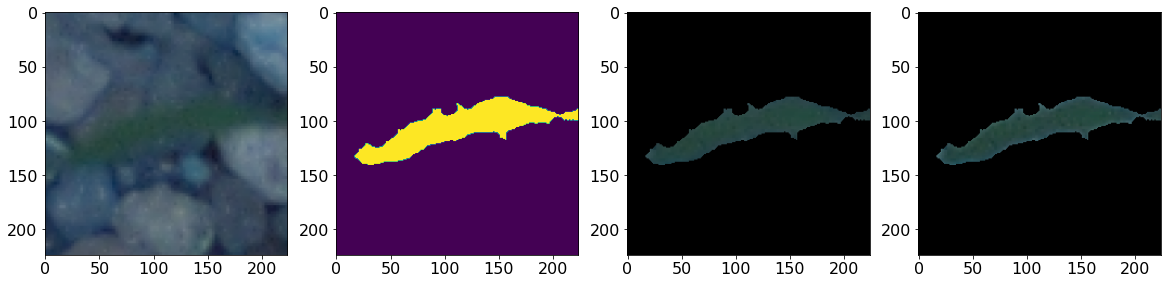

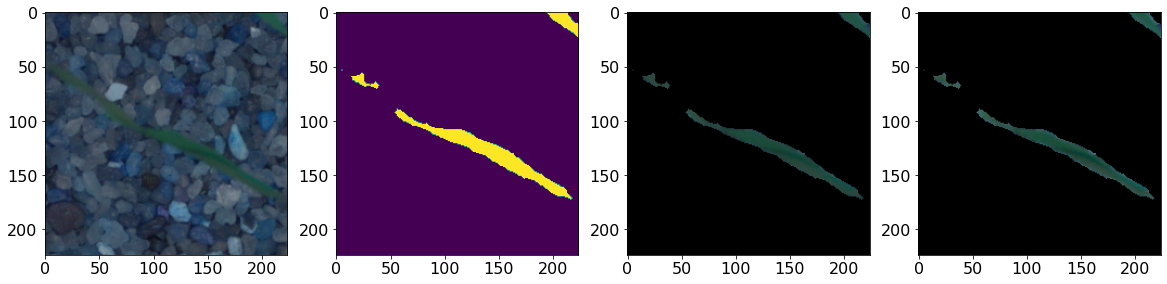

In [ ]:
## detect and segment plants in the image 

def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

def read_segmented_image(filepath, img_size):
    img = cv2.imread(os.path.join(data_dir, filepath), cv2.IMREAD_COLOR)
    img = cv2.resize(img.copy(), img_size, interpolation = cv2.INTER_AREA)

    image_mask = create_mask_for_plant(img)
    image_segmented = segment_plant(img)
    image_sharpen = sharpen_image(image_segmented)
    return img, image_mask, image_segmented, image_sharpen
     

# show some images
if show_plots:
    for i in range(4):
 
        img, image_mask, image_segmented, image_sharpen = read_segmented_image(
            train_df.loc[i,'filepath'],(224,224))
        
        fig, axs = plt.subplots(1, 4, figsize=(20, 20))
        axs[0].imshow(img.astype(np.uint8))
        axs[1].imshow(image_mask.astype(np.uint8))
        axs[2].imshow(image_segmented.astype(np.uint8))
        axs[3].imshow(image_sharpen.astype(np.uint8))

In [ ]:
## read and preprocess all training/validation/test images and labels

def preprocess_image(img):
    img /= 255.
    img -= 0.5
    img *= 2
    return img

target_image_size = 299

print('read and preprocess training and validation images')

# read, preprocess training and validation images  
x_train_valid = np.zeros((len(train_df), target_image_size, target_image_size, 3),
                         dtype='float32')
y_train_valid = train_df.loc[:, 'species_id'].values 
for i, filepath in tqdm(enumerate(train_df['filepath'])):
    
    # read original images
    #img = read_image(filepath, (target_image_size, target_image_size))
    
    # read segmented image
    _,_,_,img = read_segmented_image(filepath, (target_image_size, target_image_size))
    
    # all pixel values are now between -1 and 1
    x_train_valid[i] = preprocess_image(np.expand_dims(img.copy().astype(np.float), axis=0)) 

print('read and preprocess test images')

# read, preprocess test images  
x_test = np.zeros((len(test_df), target_image_size, target_image_size, 3), dtype='float32')
for i, filepath in tqdm(enumerate(test_df['filepath'])):
    
    # read original image
    #img = read_image(filepath, (target_image_size, target_image_size))
    
    # read segmented image
    _,_,_,img = read_segmented_image(filepath, (target_image_size, target_image_size))
    
    # all pixel values are now between -1 and 1
    x_test[i] = preprocess_image(np.expand_dims(img.copy().astype(np.float), axis=0)) 
    
print('x_train_valid.shape = ', x_train_valid.shape)
print('x_test.shape = ', x_test.shape)

read and preprocess training and validation images


2365it [09:47,  4.03it/s]


read and preprocess test images


794it [03:18,  4.00it/s]

x_train_valid.shape =  (2365, 299, 299, 3)
x_test.shape =  (794, 299, 299, 3)


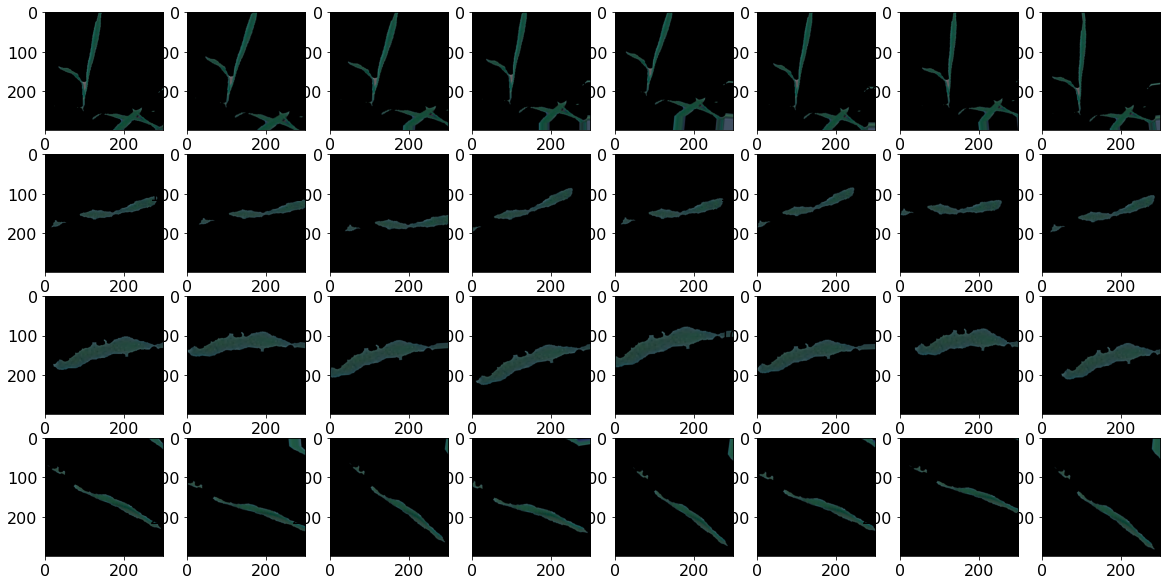

In [ ]:
## data augmentation

# generate new images via rotations, translations, flippings
def generate_images(imgs):
    imgs_len = len(imgs)
    image_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 10, width_shift_range = 0.1 , height_shift_range = 0.1,
        horizontal_flip = False, vertical_flip = False, zoom_range = 0.1)

    imgs = image_generator.flow(imgs.copy(), np.zeros(imgs_len), batch_size=imgs_len, shuffle = False).next()    
  
    # return transformed images in the same order as the original ones
    return imgs[0]


# show some examples
if show_plots:
    imgs = (((x_train_valid[0:4]+1.)/2.)*255.) # transform pixels into range [0,255]
    imgs_generated = imgs

    fig, axs = plt.subplots(4, 8, figsize=(20, 10))
    for i in range(8):
        axs[0,i].imshow(imgs_generated[0].astype(np.uint8))
        axs[1,i].imshow(imgs_generated[1].astype(np.uint8))
        axs[2,i].imshow(imgs_generated[2].astype(np.uint8))
        axs[3,i].imshow(imgs_generated[3].astype(np.uint8))   
        imgs_generated = generate_images(imgs)

# **Extract bottleneck features from Xception**
compute or load the 2048 bottleneck features for each image

In [ ]:
# compute or load bottleneck features from xception model

# train and validation images
if not load_bf_of_train_data:
    
    print('x_train_valid.shape = ', x_train_valid.shape)
    print('y_train_valid.shape = ', y_train_valid.shape)
    print('')

    print('compute bottleneck features from Xception network')

    local_start = datetime.datetime.now()
    
    # load xception base model and predict the last layer comprising 2048 neurons per image
    base_model = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
    x_train_valid_bf = base_model.predict(x_train_valid, batch_size=32, verbose=1)

    print('running time: ', datetime.datetime.now()-local_start)    
    print('')
    print('x_train_valid_bf.shape = ', x_train_valid_bf.shape)

    print('')
    print('save bottleneck features and labels for later ')
    np.save(os.path.join(os.getcwd(),'x_train_valid_bf.npy'), x_train_valid_bf)
    np.save(os.path.join(os.getcwd(),'y_train_valid.npy'), y_train_valid)

else:    
    # load bottleneck features and labels
    
    print('load bottleneck features and labels')
    
    x_train_valid_bf = np.load(os.path.join(os.getcwd(),'x_train_valid_bf_of_segmented_images.npy'))
    y_train_valid = np.load(os.path.join(os.getcwd(),'y_train_valid_of_segmented_images.npy'))

    print('x_train_valid_bf.shape = ', x_train_valid_bf.shape)
    print('y_train_valid.shape = ', y_train_valid.shape)
    
# test images
if not load_bf_of_test_data:
    # compute bottleneck features from xception model
    
    local_start = datetime.datetime.now()
    
    # load xception base model and predict the last layer comprising 2048 neurons per image
    base_model = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
    x_test_bf = base_model.predict(x_test, batch_size=32, verbose=1)
    
    print('running time: ', datetime.datetime.now()-local_start)    
    print('')
    print('x_test_bf = ',x_test_bf.shape)

    print('save bottleneck features ')
    np.save(os.path.join(os.getcwd(),'x_test_bf.npy'), x_test_bf)
    

else:
    # load bottleneck features and compute the predictions
    print('load bottleneck features')
    x_test_bf = np.load(os.path.join(os.getcwd(),'x_test_bf_of_segmented_images.npy'))
    print('x_test_bf.shape = ', x_test_bf.shape)

x_train_valid.shape =  (2365, 299, 299, 3)
y_train_valid.shape =  (2365,)

compute bottleneck features from Xception network
74/74 [==============================] - 579s 8s/step
running time:  0:09:41.449166

x_train_valid_bf.shape =  (2365, 2048)

save bottleneck features and labels for later 
25/25 [==============================] - 195s 8s/step
running time:  0:03:16.578210

x_test_bf =  (794, 2048)
save bottleneck features 


In [ ]:
## compute or load bottleneck features for augmented data

if use_aug_data:

    if not load_bf_of_aug_data:

        for i in range(2):
            x_aug_tmp = generate_images(x_train_valid)
            y_aug_tmp = y_train_valid

            print('compute bottleneck features from Xception network')
            print('x_aug_tmp.shape = ', x_aug_tmp)
            print('y_aug_tmp.shape = ', y_aug_tmp)

            local_start = datetime.datetime.now()

            # load xception model and predict the last layer having 2048 neurons per image
            base_model = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
            x_aug_tmp_bf = base_model.predict(x_aug_tmp, batch_size=32, verbose=1)
            
            print('running time: ', datetime.datetime.now()-local_start)    
            print('')
            print('x_aug_tmp_bf.shape = ', x_aug_tmp_bf.shape)
            
            if i==0:
                x_aug = x_aug_tmp_bf
                y_aug = y_aug_tmp
            else:
                x_aug = np.concatenate([x_aug,x_aug_tmp_bf])
                y_aug = np.concatenate([y_aug,y_aug_tmp])
            
            print('')
            print('save bottleneck features and labels for later ')
            np.save(os.path.join(os.getcwd(),'x_aug.npy'), x_aug)
            np.save(os.path.join(os.getcwd(),'y_aug.npy'), y_aug)

     
    else:
        # load bottleneck features and compute the predictions

        print('load bottleneck features')
        x_aug_bf = np.load(os.path.join(os.getcwd(), 'x_aug_bf_of_segmented_images.npy'))
        y_aug = np.load(os.path.join(os.getcwd(), 'y_aug_of_segmented_images.npy'))

        print('x_aug_bf.shape = ', x_aug_bf.shape)
        print('y_aug.shape = ', y_aug.shape)

In [ ]:
## combine files
if False:
    x_aug_bf_1 = np.load(os.path.join(os.getcwd(), 'x_aug_bf_of_segmented_images.npy'))
    y_aug_1 = np.load(os.path.join(os.getcwd(), 'y_aug_of_segmented_images.npy'))
    print(x_aug_bf_1.shape, y_aug_1.shape)
    x_aug_bf_2 = np.load(os.path.join(os.getcwd(), 'x_aug_bf.npy'))
    y_aug_2 = np.load(os.path.join(os.getcwd(), 'y_aug.npy'))
    print(x_aug_bf_2.shape, y_aug_2.shape)
    x_aug_bf = np.concatenate([x_aug_bf_1,x_aug_bf_2])
    y_aug = np.concatenate([y_aug_1,y_aug_2])
    print(x_aug_bf.shape,y_aug.shape)
    #np.save(os.path.join(os.getcwd(),'x_aug_bf.npy'), x_aug_bf)
    #np.save(os.path.join(os.getcwd(),'y_aug.npy'), y_aug)

**1-B)Train tune and test AIML image classifier model**

In [ ]:
#split data into training and validation sets
#set_seed = 123

# use one-hot encoding for categorial labels
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def one_hot_to_dense(labels_one_hot):
    num_labels = labels_one_hot.shape[0]
    num_classes = labels_one_hot.shape[1]
    labels_dense = np.where(labels_one_hot == 1)[1]      
    return labels_dense

# function to shuffle randomly train and validation data
def shuffle_train_valid_data():
    
    print('shuffle train and validation data')
    
    # shuffle train and validation data of original data
    perm_array = np.arange(len(x_train_valid_bf)) 
    np.random.shuffle(perm_array)
    
    # split train and validation sets based on original data
    x_train_bf = x_train_valid_bf[perm_array[:train_set_size]]
    y_train = dense_to_one_hot(y_train_valid[perm_array[:train_set_size]], num_species)
    x_valid_bf = x_train_valid_bf[perm_array[-valid_set_size:]]
    y_valid = dense_to_one_hot(y_train_valid[perm_array[-valid_set_size:]], num_species)
    
    # augment train data by generated images
    if use_aug_data:
        
        x_train_bf = np.concatenate([x_train_bf, x_aug_bf])
        y_train = np.concatenate([y_train, dense_to_one_hot(y_aug, num_species)])
        
        # shuffle data
        perm_array = np.arange(len(x_train_bf)) 
        np.random.shuffle(perm_array)
        
        x_train_bf = x_train_bf[perm_array]
        y_train = y_train[perm_array]
         
    return x_train_bf, y_train, x_valid_bf, y_valid 

if valid_set_size_percentage > 0:
    # split into train and validation sets
    valid_set_size = int(len(x_train_valid_bf) * valid_set_size_percentage/100);
    train_set_size = len(x_train_valid_bf) - valid_set_size;
else:
    # train on all available data
    valid_set_size = int(len(x_train_valid_bf) * 0.1);
    train_set_size = len(x_train_valid_bf)

# split into train and validation sets including shuffling
x_train_bf, y_train, x_valid_bf, y_valid = shuffle_train_valid_data() 

print('x_train_bf.shape = ', x_train_bf.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid_bf.shape = ', x_valid_bf.shape)
print('y_valid.shape = ', y_valid.shape)

shuffle train and validation data
x_train_bf.shape =  (2129, 2048)
y_train.shape =  (2129, 12)
x_valid_bf.shape =  (236, 2048)
y_valid.shape =  (236, 12)


**1.B.1 -Use supervised learning algorithms for training**

In [ ]:
## Logisitic Regression Alogorithm

cv_num = 1

acc_logreg_train = acc_logreg_valid =0 
y_test_pred_proba_logreg = 0

for i in range(cv_num):
    
    shuffle_train_valid_data() # shuffle data
    
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    logreg.fit(x_train_bf, one_hot_to_dense(y_train))
   
    acc_logreg_train += logreg.score(x_train_bf, one_hot_to_dense(y_train))
    acc_logreg_valid += logreg.score(x_valid_bf, one_hot_to_dense(y_valid))
    y_test_pred_proba_logreg += logreg.predict_proba(x_test_bf)
      
acc_logreg_train /= cv_num
acc_logreg_valid /= cv_num
y_test_pred_proba_logreg /= cv_num
y_test_pred_class_logreg = np.argmax(y_test_pred_proba_logreg, axis = 1)

print('Logistic Regression')
print('Accuracy train/valid = %.4f/%.4f'%(acc_logreg_train, acc_logreg_valid))
print('y_test_pred_class_logreg.shape = ', y_test_pred_class_logreg.shape)

shuffle train and validation data
Logistic Regression
Accuracy train/valid = 0.9986/0.8856
y_test_pred_class_logreg.shape =  (794,)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Using Logistic Regression algorithm, accuracy score of using train data is 99.86% and Validation data is 88.56% 

** Logistic Regression Model evalation-Predict species and submit test results**

In [ ]:
y_test_pred_class = y_test_pred_class_logreg
test_df['species_id'] = y_test_pred_class
test_df['species'] = [species[sp] for sp in y_test_pred_class]
logisticregression= test_df[['file', 'species']]
print(logisticregression.head(5))
logisticregression.to_csv('Logistic regression.csv', index=False)


            file            species
0  f9b6bfb00.png           Cleavers
1  fea3da57c.png         Sugar beet
2  f1f7c833f.png           Charlock
3  fe29629fb.png   Common Chickweed
4  f48916a8c.png  Scentless Mayweed


Logistic regression excel displays the image file with predicted Species class

In [ ]:
## Random Forest Algorithm

cv_num = 1

acc_randomforest_train = acc_randomforest_valid = 0
y_test_pred_proba_randomforest = 0

for i in range(cv_num):
    
    shuffle_train_valid_data() # shuffle data
    
    random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators=10)
    random_forest.fit(x_train_bf, one_hot_to_dense(y_train))
   
    acc_randomforest_train += random_forest.score(x_train_bf, one_hot_to_dense(y_train))
    acc_randomforest_valid += random_forest.score(x_valid_bf, one_hot_to_dense(y_valid))

    y_test_pred_proba_randomforest += random_forest.predict_proba(x_test_bf)
    
acc_randomforest_train /= cv_num
acc_randomforest_valid /= cv_num
y_test_pred_proba_randomforest /= cv_num
y_test_pred_class_randomforest = np.argmax(y_test_pred_proba_randomforest, axis = 1)

print('Random Forest')
print('Accuracy train/valid = %.4f/%.4f'%(acc_randomforest_train, acc_randomforest_valid))
print('y_test_pred_class_randomforest.shape = ', y_test_pred_class_randomforest.shape)

shuffle train and validation data
Random Forest
Accuracy train/valid = 0.9958/0.7076
y_test_pred_class_randomforest.shape =  (794,)


Using Random Forest, accuracy score of train data is 99.58% and validation data is 70.76%

**Random Forest Model evaluation** -Predict species and submit test results

In [ ]:
y_test_pred_class = y_test_pred_class_randomforest
test_df['species_id'] = y_test_pred_class
test_df['species'] = [species[sp] for sp in y_test_pred_class]
randomforest=test_df[['file', 'species']]
print(randomforest.head())
randomforest.to_csv('Random Forest.csv', index=False)



            file            species
0  f9b6bfb00.png           Cleavers
1  fea3da57c.png         Sugar beet
2  f1f7c833f.png    Shepherds Purse
3  fe29629fb.png   Common Chickweed
4  f48916a8c.png  Scentless Mayweed


Random Forest excel displays the image file with predicted Species class

**1.B.2 -Use neural networks for training**

In [ ]:
## Neural Networks with Tensorflow

# permutation array for shuffling train data
perm_array_train = np.arange(len(x_train_bf)) 
index_in_epoch = 0

# function: to get the next mini batch
def get_next_batch(batch_size):
    
    global index_in_epoch, perm_array_train
  
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > train_set_size:
        np.random.shuffle(perm_array_train) # shuffle data
        start = 0 # start next epoch
        index_in_epoch = batch_size
              
    end = index_in_epoch
    
    return x_train_bf[perm_array_train[start:end]], y_train[perm_array_train[start:end]]

x_size = x_train_bf.shape[1] # number of features
y_size = num_species # binary variable
n_n_fc1 = 1024 # number of neurons of first layer
n_n_fc2 = num_species # number of neurons of second layer
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# variables for input and output 
x_data = tf.placeholder('float', shape=[None, x_size])
y_data = tf.placeholder('float', shape=[None, y_size])

# 1.layer: fully connected
W_fc1 = tf.Variable(tf.truncated_normal(shape = [x_size, n_n_fc1], stddev = 0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape = [n_n_fc1]))  
h_fc1 = tf.nn.relu(tf.matmul(x_data, W_fc1) + b_fc1)

# add dropout
tf_keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, tf_keep_prob)

# 3.layer: fully connected
W_fc2 = tf.Variable(tf.truncated_normal(shape = [n_n_fc1, n_n_fc2], stddev = 0.1)) 
b_fc2 = tf.Variable(tf.constant(0.1, shape = [n_n_fc2]))  
z_pred = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# cost function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_data, 
                                                                       logits=z_pred));

# optimisation function
tf_learn_rate = tf.placeholder(dtype='float', name="tf_learn_rate")
train_step = tf.train.AdamOptimizer(tf_learn_rate).minimize(cross_entropy)

# evaluation
y_pred = tf.cast(tf.nn.softmax(z_pred), dtype = tf.float32);
y_pred_class = tf.cast(tf.argmax(y_pred,1), tf.int32)
y_data_class = tf.cast(tf.argmax(y_data,1), tf.int32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred_class, y_data_class), tf.float32))

# parameters
cv_num = 1 # number of cross validations
n_epoch = 15 # number of epochs
batch_size = 50 
keep_prob = 0.33 # dropout regularization with keeping probability
learn_rate_range = [0.01,0.005,0.0025,0.001,0.001,0.001,0.00075,0.0005,0.00025,0.0001,
                   0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001];
learn_rate_step = 3 # in terms of epochs

acc_train_DNN = 0
acc_valid_DNN = 0
loss_train_DNN = 0
loss_valid_DNN = 0
y_test_pred_proba_DNN = 0
y_valid_pred_proba = 0

# use cross validation
for j in range(cv_num):
    
    # start TensorFlow session and initialize global variables
    sess = tf.InteractiveSession() 
    sess.run(tf.global_variables_initializer())  

    # shuffle train/validation splits
    shuffle_train_valid_data() 
    n_step = -1;

    # training model
    for i in range(int(n_epoch*train_set_size/batch_size)):

        if i%int(learn_rate_step*train_set_size/batch_size) == 0:
            n_step += 1;
            learn_rate = learn_rate_range[n_step];
            print('learnrate = ', learn_rate)
        
        x_batch, y_batch = get_next_batch(batch_size)
        
        sess.run(train_step, feed_dict={x_data: x_batch, y_data: y_batch, 
                                        tf_keep_prob: keep_prob, 
                                        tf_learn_rate: learn_rate})

        if i%int(0.25*train_set_size/batch_size) == 0:
            
            train_loss = sess.run(cross_entropy,
                                  feed_dict={x_data: x_train_bf[:valid_set_size], 
                                             y_data: y_train[:valid_set_size], 
                                             tf_keep_prob: 1.0})

            
            train_acc = accuracy.eval(feed_dict={x_data: x_train_bf[:valid_set_size], 
                                                 y_data: y_train[:valid_set_size], 
                                                 tf_keep_prob: 1.0})    

            valid_loss = sess.run(cross_entropy,feed_dict={x_data: x_valid_bf, 
                                                           y_data: y_valid, 
                                                           tf_keep_prob: 1.0})

           
            valid_acc = accuracy.eval(feed_dict={x_data: x_valid_bf, 
                                                 y_data: y_valid, 
                                                 tf_keep_prob: 1.0})      

            print('%.2f epoch: train/val loss = %.4f/%.4f, train/val acc = %.4f/%.4f'%(
                (i+1)*batch_size/train_set_size, train_loss, valid_loss, train_acc, valid_acc))

    
    acc_train_DNN += train_acc
    acc_valid_DNN += valid_acc
    loss_train_DNN += train_loss
    loss_valid_DNN += valid_loss
    
    y_valid_pred_proba += y_pred.eval(feed_dict={x_data: x_valid_bf, tf_keep_prob: 1.0}) 
    y_test_pred_proba_DNN += y_pred.eval(feed_dict={x_data: x_test_bf, tf_keep_prob: 1.0}) 

    sess.close()
        
acc_train_DNN /= float(cv_num)
acc_valid_DNN /= float(cv_num)
loss_train_DNN /= float(cv_num)
loss_valid_DNN /= float(cv_num)

# final validation prediction
y_valid_pred_proba /= float(cv_num)
y_valid_pred_class = np.argmax(y_valid_pred_proba, axis = 1)

# final test prediction
y_test_pred_proba_DNN /= float(cv_num)
y_test_pred_class_DNN = np.argmax(y_test_pred_proba_DNN, axis = 1)

# final loss and accuracy
print('')
print('final: train/val loss = %.4f/%.4f, train/val acc = %.4f/%.4f'%(loss_train_DNN, 
                                                                      loss_valid_DNN, 
                                                                      acc_train_DNN, 
                                                                      acc_valid_DNN))

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

shuffle train and validation data
learnrate =  0.01
0.02 epoch: train/val loss = 12.3805/15.7608, train/val acc = 0.1186/0.0847
0.26 epoch: train/val loss = 2.1528/3.2963, train/val acc = 0.6398/0.5678
0.49 epoch: train/val loss = 1.1735/1.5275, train/val acc = 0.7034/0.6568
0.73 epoch: train/val loss = 0.5681/0.7791, train/val acc = 0.7797/0.7458
0.96 epoch: train/val loss = 0.5241/0.7104, train/val acc = 0.8008/0.7500
1.20 epoch: train/val loss = 0.4867/0.6606, train/val acc = 0.8008/0.7458
1.43 epoch: train/val loss = 0.3921/0.5940, train/val acc = 0.8263/0.7373
1.67 epoch: train/val loss = 0.4128/0

Using Neural network , accuracy score of training data is 96.61% and validation data is 88.14%

**Neural Network Model evaluation** -Predict species and submit test results

In [ ]:
y_test_pred_class = y_test_pred_class_DNN
test_df['species_id'] = y_test_pred_class
test_df['species'] = [species[sp] for sp in y_test_pred_class]
neuralnetwork=test_df[['file', 'species']]
print(neuralnetwork.head(5))
neuralnetwork.to_csv('Neural Network.csv', index=False)


            file            species
0  f9b6bfb00.png           Cleavers
1  fea3da57c.png         Sugar beet
2  f1f7c833f.png           Charlock
3  fe29629fb.png   Common Chickweed
4  f48916a8c.png  Scentless Mayweed


Neural Network excel displays the image file with predicted Species class

**2.C Use CNN for training**

In [ ]:
import numpy as np
import pandas as pd
from glob import glob
import cv2
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm
import time
%matplotlib inline

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Sequential, model_from_json
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense ,Input
from keras.optimizers import Adam ,RMSprop

In [ ]:

def load_dataset(path):
    data=load_files(path)
    plant_files=np.array(data['filenames'])
    plant_targets=np_utils.to_categorical(np.array(data['target']),12)
    return plant_files,plant_targets

print('Loading Train Files and Targets')
train_files, train_targets = load_dataset('/content/drive/MyDrive/Colab Notebooks/Plant seedling classification data/train')
print('Loading Complete!')
print('There are %d training plant images.' % len(train_files))

Loading Train Files and Targets
Loading Complete!
There are 4408 training plant images.


In [ ]:
#list of plant names
plant_names= [item[58:-1] for item in sorted(glob("/content/drive/MyDrive/Colab Notebooks/Plant seedling classification data/train/*/"))]
print('There are %d total plant categories.' % len(plant_names))

There are 12 total plant categories.


In [ ]:
plant_names

['sification data/train/Black-grass',
 'sification data/train/Charlock',
 'sification data/train/Cleavers',
 'sification data/train/Common Chickweed',
 'sification data/train/Common wheat',
 'sification data/train/Fat Hen',
 'sification data/train/Loose Silky-bent',
 'sification data/train/Maize',
 'sification data/train/Scentless Mayweed',
 'sification data/train/Shepherds Purse',
 'sification data/train/Small-flowered Cranesbill',
 'sification data/train/Sugar beet']

In [ ]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(256, 256))
    # convert PIL.Image.Image type to 3D tensor with shape (256, 256, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 256, 256, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
# pre-process Training data
train_tensors = paths_to_tensor(train_files).astype('float32')/255

100%|██████████| 4408/4408 [00:46<00:00, 95.76it/s] 


In [ ]:
train_tensors.shape

(4408, 256, 256, 3)

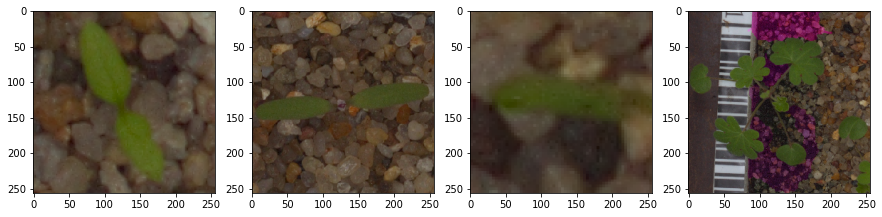

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15,15))

axs[0].imshow(train_tensors[0])
axs[1].imshow(train_tensors[10])
axs[2].imshow(train_tensors[42])
axs[3].imshow(train_tensors[65])

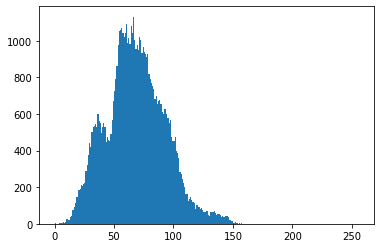

In [ ]:
img = cv2.imread('train/Cleavers/005b4a3e3.png')
plt.hist(img.ravel(),256,[0,256]); plt.show()

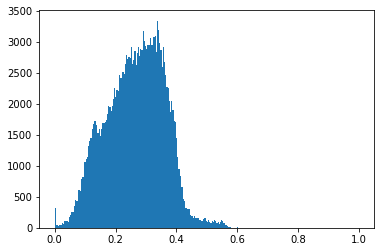

In [ ]:
plt.hist(train_tensors[0].ravel(),256,[0,1])
plt.show()

In [ ]:
seed = 31
np.random.seed(seed)



# Split the train and the validation set
train_tensors, val_train, train_targets, val_targets = train_test_split(train_tensors,
                                              train_targets, 
                                              test_size=0.15,
                                              random_state=seed
                                             )

print(train_tensors.shape)
print(val_train.shape)
print(train_targets.shape)
print(val_targets.shape)

(3746, 256, 256, 3)
(662, 256, 256, 3)
(3746, 12)
(662, 12)


In [ ]:
#Build CNN Model
model= Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))


model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(GlobalAveragePooling2D())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(12,activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 128, 128, 32)      12832     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 64, 64, 32)       

In [ ]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/cnn_model_wo_aug_af.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, epochs = 15, validation_data = (val_train,val_targets),callbacks=[checkpointer],batch_size = 64)

Epoch 1/15
59/59 [==============================] - 911s 15s/step - loss: 2.4828 - accuracy: 0.1316 - val_loss: 2.3869 - val_accuracy: 0.1360

Epoch 00001: val_loss improved from inf to 2.38692, saving model to saved_models/cnn_model_wo_aug_af.hdf5
Epoch 2/15
59/59 [==============================] - 909s 15s/step - loss: 2.4160 - accuracy: 0.1455 - val_loss: 2.2980 - val_accuracy: 0.2598

Epoch 00002: val_loss improved from 2.38692 to 2.29804, saving model to saved_models/cnn_model_wo_aug_af.hdf5
Epoch 3/15
59/59 [==============================] - 906s 15s/step - loss: 2.2776 - accuracy: 0.2241 - val_loss: 2.0594 - val_accuracy: 0.2915

Epoch 00003: val_loss improved from 2.29804 to 2.05938, saving model to saved_models/cnn_model_wo_aug_af.hdf5
Epoch 4/15
59/59 [==============================] - 911s 15s/step - loss: 2.0569 - accuracy: 0.2844 - val_loss: 2.0516 - val_accuracy: 0.3157

Epoch 00004: val_loss improved from 2.05938 to 2.05160, saving model to saved_models/cnn_model_wo_aug_

KeyboardInterrupt: ignored

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [ ]:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_tensors)

In [ ]:
batch = 32

checkpointer = ModelCheckpoint(filepath='saved_models/cnn_model_with_aug_af.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit_generator(datagen.flow(train_tensors,train_targets,batch_size=batch),epochs = 3, validation_data = (val_train,val_targets),
                              verbose = 1, steps_per_epoch=train_tensors.shape[0] // batch
                              , callbacks=[learning_rate_reduction, checkpointer])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
117/117 [==============================] - 975s 8s/step - loss: 1.1516 - accuracy: 0.6120 - val_loss: 1.5862 - val_accuracy: 0.4622

Epoch 00001: val_loss improved from inf to 1.58619, saving model to saved_models/cnn_model_with_aug_af.hdf5
Epoch 2/3
117/117 [==============================] - 973s 8s/step - loss: 1.0805 - accuracy: 0.6381 - val_loss: 0.9224 - val_accuracy: 0.6964

Epoch 00002: val_loss improved from 1.58619 to 0.92244, saving model to saved_models/cnn_model_with_aug_af.hdf5
Epoch 3/3
117/117 [==============================] - 987s 8s/step - loss: 0.9981 - accuracy: 0.6597 - val_loss: 0.8531 - val_accuracy: 0.7175

Epoch 00003: val_loss improved from 0.92244 to 0.85306, saving model to saved_models/cnn_model_with_aug_af.hdf5


In [97]:
model.load_weights('saved_models/cnn_model_with_aug_af.hdf5')
accuracy=model.evaluate(x=val_train,y=val_targets,batch_size=32)
print("Loss of the model: {} , Accuracy of Model :{} ".format(accuracy[0],accuracy[1]))

21/21 [==============================] - 39s 2s/step - loss: 0.8531 - accuracy: 0.7175
Loss of the model: 0.8530619144439697 , Accuracy of Model :0.7175226807594299 


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


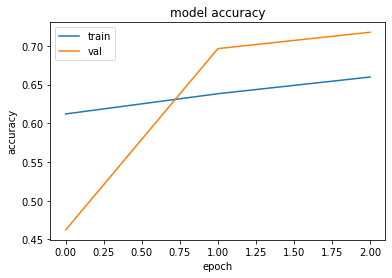

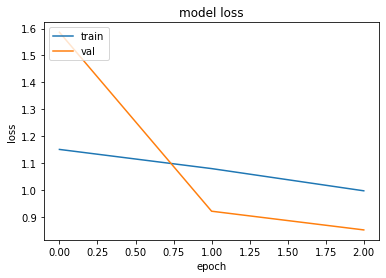

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def one_hot_to_dense(labels_one_hot):
    num_labels = labels_one_hot.shape[0]
    num_classes = labels_one_hot.shape[1]
    labels_dense = np.where(labels_one_hot == 1)[1]      
    return labels_dense

In [ ]:
validation_predictions = model.predict_classes(val_train)
report=classification_report(one_hot_to_dense(val_targets),validation_predictions)
print(report)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.54      0.92      0.68        60
           2       0.62      0.62      0.62        39
           3       0.91      0.89      0.90        90
           4       0.54      0.68      0.60        28
           5       0.78      0.70      0.74        89
           6       0.85      0.85      0.85        97
           7       0.60      0.60      0.60        20
           8       0.65      0.73      0.69        75
           9       0.46      0.40      0.43        30
          10       0.81      0.72      0.76        71
          11       0.74      0.61      0.67        38

    accuracy                           0.72       662
   macro avg       0.63      0.64      0.63       662
weighted avg       0.71      0.72      0.71       662



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
           'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
num_species = len(species)
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': species, 'abbreviation': abbreviation})

,class,abbreviation
0,Black-grass,BG
1,Charlock,Ch
2,Cleavers,Cl
3,Common Chickweed,CC
4,Common wheat,CW
5,Fat Hen,FH
6,Loose Silky-bent,LSB
7,Maize,M
8,Scentless Mayweed,SM
9,Shepherds Purse,SP


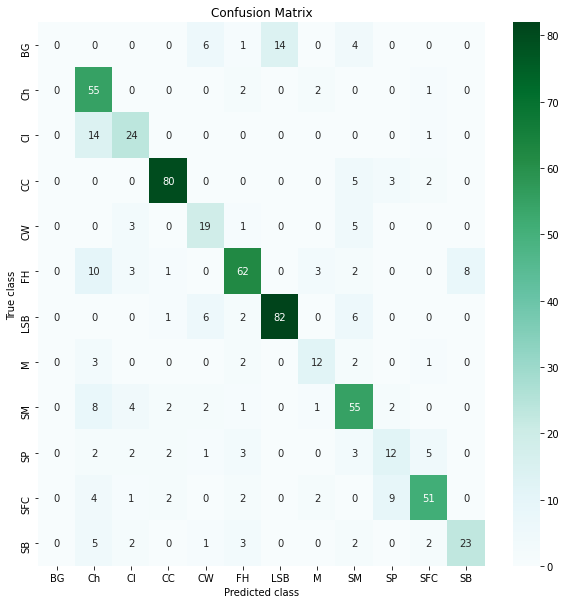

In [ ]:

conf_mat= confusion_matrix(one_hot_to_dense(val_targets), validation_predictions)
fig, ax = plt.subplots(1,figsize=(10,10))

ax = sns.heatmap(conf_mat, ax=ax, cmap=plt.cm.BuGn, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

In [95]:
model_json = model.to_json()
with open("saved_models/model_after_rev.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("saved_models/model_after_rev.h5")
print("Saved model to disk")

Saved model to disk


**Use various CNN with transferred learning models for training**

In [84]:

import fnmatch
import os
import numpy as np
import pandas as pd
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
np.random.seed(21)

path = '/content/drive/MyDrive/Colab Notebooks/Plant seedling classification data/train/'
train_label = []
train_img = []
label2num = {'Loose Silky-bent':0, 'Charlock':1, 'Sugar beet':2, 'Small-flowered Cranesbill':3,
             'Common Chickweed':4, 'Common wheat':5, 'Maize':6, 'Cleavers':7, 'Scentless Mayweed':8,
             'Fat Hen':9, 'Black-grass':10, 'Shepherds Purse':11}
for i in os.listdir(path):
    label_number = label2num[i]
    new_path = path+i+'/'
    for j in fnmatch.filter(os.listdir(new_path), '*.png'):
        temp_img = image.load_img(new_path+j, target_size=(128,128))
        train_label.append(label_number)
        temp_img = image.img_to_array(temp_img)
        train_img.append(temp_img)

train_img = np.array(train_img)

train_y=pd.get_dummies(train_label)
train_y = np.array(train_y)
train_img=preprocess_input(train_img)

print('Training data shape: ', train_img.shape)
print('Training labels shape: ', train_y.shape)

import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import VGG16


def vgg16(num_classes=None):

    model = VGG16(weights='imagenet', include_top=False,input_shape=(128,128,3))
    model.layers.pop()
    model.layers.pop()
    model.layers.pop()

    model.outputs = [model.layers[-1].output]

    model.layers[-2].outbound_nodes= []
    x=Conv2D(256, kernel_size=(2,2),strides=2)(model.output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)    
    x=Conv2D(128, kernel_size=(2,2),strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x=Flatten()(x)
    x=Dense(num_classes, activation='softmax')(x)

    model=Model(model.input,x)

    for layer in model.layers[:15]:

        layer.trainable = False


    return model

Training data shape:  (4408, 128, 128, 3)
Training labels shape:  (4408, 12)


In [83]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

In [ ]:

from keras import backend as K
num_classes=12
vm = vgg16(num_classes)
vm.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy',fscore])
vm.summary()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(train_tensors,train_targets, y,test_size=0.1, random_state=42)
from keras.callbacks import ModelCheckpoint
epochs = 10
batch_size = 32
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

vggmodel.fit(X_train,Y_train,batch_size=128,epochs=20,verbose=1, shuffle=True, validation_data=(X_valid,Y_valid), callbacks=[model_checkpoint])

In [87]:
import matplotlib.pyplot as plt
def plot_model(model):
    plots = [i for i in model.history.history.keys() if i.find('val_') == -1]
    plt.figure(figsize=(10,10))

    for i, p in enumerate(plots):
        plt.subplot(len(plots), 2, i + 1)
        plt.title(p)
        plt.plot(model.history.history[p], label=p)
        plt.plot(model.history.history['val_'+p], label='val_'+p)
        plt.legend()

    plt.show()
    
plot_model(model)

<Figure size 720x720 with 0 Axes>

In [89]:
model.load_weights('saved_models/model_after_rev.h5')

In [ ]:
#Convert dataframe to csv
df.to_csv("/output/submit.csv",index=False) 

#Submit the csv
print('Submitting csv')
!kg submit submit.csv -u <username> -p <password> -c plant-seedlings-classification

In [ ]:
prob=[]
num=[]
test_img=[]
test_path = '/content/drive/MyDrive/Colab Notebooks/Plant seedling classification data/test'
test_all = fnmatch.filter(os.listdir(test_path), '*.png')

test_img=[]
for i in range(len(test_all)):
    path=test_path+'/'+test_all[i]
    temp_img=image.load_img(path,target_size=(128,128))
    temp_img=image.img_to_array(temp_img)
    test_img.append(temp_img) 
test_img=np.array(test_img)    
test_img=preprocess_input(test_img)


test_labels=[]
pred=model.predict(test_img)
num2label =  {0:'Loose Silky-bent', 1:'Charlock',2: 'Sugar beet',3: 'Small-flowered Cranesbill',
              4:'Common Chickweed',5: 'Common wheat',6: 'Maize', 7:'Cleavers', 8:'Scentless Mayweed',
             9: 'Fat Hen', 10:'Black-grass', 11:'Shepherds Purse'}
for i in range(len(test_all)):
    max_score =0
    lab=-1
    for j in range(12):
        if pred[i][j]>max_score:
            max_score=pred[i][j]
            lab=j
    test_labels.append(num2label[lab])


d = {'file': test_all, 'species': test_labels}
df = pd.DataFrame(data=d)
print(df.head(5))

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import os
from keras.preprocessing import image
print(os.getcwd())
model = load_model('saved_models/model_after_rev.h5')

In [ ]:

dict_map = { 
    0 : 'Black-grass',
    1 : 'Charlock',
    2 : 'Cleavers',
    3 : 'Common Chickweed',
    4 : 'Common wheat',
    5 : 'Fat Hen',
    6 : 'Loose Silky-bent',
    7 : 'Maize',
    8 : 'Scentless Mayweed',
    9 : 'Shepherds Purse',
    10 : 'Small-flowered Cranesbill',
    11 : 'Sugar beet'}

In [ ]:
def predict(path):
    pic = image.load_img(path, target_size=(196, 196, 3))
    x = image.img_to_array(pic)
    x = np.reshape(x, (1, 196, 196, 3))
    x = x/255
    y = model.predict(x, batch_size=None)
    print(y)
    #ref = np.asarray([0,1,2,3,4,5,6,7,8,9,10,11])
    #ref = np.reshape(ref,(1,12))
    prediction = np.argmax(y)
    print(prediction)
    output = dict_map[int(prediction)]
    print(output)    
    return output

GUI generation code

In [ ]:
from tkinter import *
from PIL import Image, ImageTk
from tkinter import filedialog as tkFileDialog
from tkinter import font as tkFont

class MyFirstGUI:
   pictures = {"path" : "./sample_images_for_gui/"} #Path for the sample images to display
   images = []                             #List to store the images
   image_names = []                        #List to store the class name for each image
   filename = None                         #Class variable to store the file given by the user
   input_buf_img = None                          #Place to keep the input img
   prediction = None
   #Intialization method for the class
   def __init__(self, master):
      self.master = master
      master.geometry("1000x700")     
      master.title("Plant Seedling Classifier")
      self.logo_frame = Frame(master)                             #Frame to display explanation text
      self.samples_frame = Frame(master, width=500, height = 800) #Frame to display the images

   #Method to construct and display the contents in a windoe
   def configure(self):
      #Heading
      self.heading = Label(self.master, text = "Welcome to Seedling Classifier!", fg="red")
      font = tkFont.Font(size=25, weight="bold")
      self.heading.configure(font=font)
      self.heading.pack()

      #Explanation text
      font = tkFont.Font(size=14)
      self.text_label = Label(self.logo_frame, text = "CNN is used to classify the given plant image to one of the 12 classes displayed below.", font=font).pack()
      self.logo_frame.pack()

      #Read the sample image of each class
      for each_file in os.listdir(self.pictures['path']):
         image = Image.open(self.pictures['path']+each_file)
         image = image.resize((100, 100), Image.ANTIALIAS)
         img = ImageTk.PhotoImage(image)
         self.images.append(img)
         self.image_names.append(each_file[:-4])

      #Display the sample image for each class
      count = 0;
      for each_img, image_name in zip(self.images, self.image_names):
         row = int(count/6)
         column = int(count%6)
         count += 1
         label = Label(self.samples_frame, compound='top' , text = image_name, font=('20'),  image = each_img).grid(row = row, column = column)
      self.samples_frame.pack()

      #Button to load the input file image
      self.filebutton = Button(self.master, text='Upload Image File to Classify', font=('30'), command = self.selectFile, pady=1)
      self.filebutton.pack()

      #Button to submit the selected/loaded image 
      self.okbutton = Button(self.master, text='Submit File', font=('30'), command = self.processFile, pady = 1)
      self.okbutton.pack()

      #Initialize a box to display the submitted image
      self.input_img = Label(self.master, text=" ", image = self.input_buf_img)
      self.input_img.pack()

      #Initialize the text box for displaying the Messages
      font = tkFont.Font(size=14)
      self.msgBox = Message(self.master, text =" ", width = 300, font=font, fg='red', pady=5)
      self.msgBox.pack()
   
   #Function to be invoked when Upload button is clicked
   def selectFile(self):
      self.filename =  tkFileDialog.askopenfile(parent = self.master, mode = 'r', title='Choose a file')
      #print(self.filename.name)

   #Function to be invoked when submit button is clicked
   def processFile(self):
      fname = self.filename.name
      self.filename.close()
      if fname == None:
         self.msgBox.configure(text = "No file given")

      else:
         print(fname)
         image = Image.open(fname)
         image = image.resize((200, 200), Image.ANTIALIAS)
         self.input_buf_img = ImageTk.PhotoImage(image)
         self.input_img.configure(image = self.input_buf_img)
         self.msgBox.configure(text = "")
         #Display a default message currently
         #data = fname.read()
         #Image.open(fname)
         self.prediction = predict(fname)
         self.msgBox.configure(text = "The image is of "+ self.prediction)

root = Tk()
my_gui = MyFirstGUI(root)
my_gui.configure()

root.mainloop()